In [16]:
from Maximus_optimized_non_dominated import Multi_Fair as maximus
from sklearn.model_selection import StratifiedShuffleSplit as ss
from DataPreprocessing.my_utils import get_score,get_fairness,vis
import numpy as np

In [4]:
from DataPreprocessing.load_credit import load_credit
X, y, sa_index, p_Group, x_control,F = load_credit()
protected=[F[v] for v in sa_index]
dt='Credit'

[2.659488361359545, -1.1375335092714727]
Features we will be using for classification are: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target'] 



In [13]:
sss = ss(n_splits=2,test_size=0.4) #for reporting experiments use n_splits=10
preference=[[0,0,1],[0,1,1],[1,0,0],[1,1,0],[1,0,1],[0,1,0],[1.0,0.05,0.05]]

In [14]:
soln_per_dir={}
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf=maximus(n_estimators=499,saIndex=sa_index,
        saValue=p_Group,
        preference=preference)
    clf.fit(X_train,y_train)
    print(clf.preference_direction_to_solution_mapping)
    for (a,b,c) in clf.preference_direction_to_solution_mapping:
        clf.estimators_=clf.estimators_[:c]
        clf.estimator_alphas_=clf.estimator_alphas_[:c]
        pred=clf.predict(X_test)
        #print(confusion_matrix(y_test,pred))
        if str(a) in soln_per_dir:
            soln_per_dir[str(a)].append([test_index,pred])
        else:
            soln_per_dir[str(a)]=[]
            soln_per_dir[str(a)].append([test_index,pred])

[(array([1.  , 0.05, 0.05]), array([0.23533333, 0.17313336, 0.01466386]), 369), (array([1., 0., 1.]), array([0.21533333, 0.26653268, 0.02531255]), 165), (array([1., 1., 0.]), array([0.19594444, 0.39977814, 0.01248274]), 96), (array([0., 1., 0.]), array([0.18338889, 0.47652405, 0.017176  ]), 56), (array([0., 1., 1.]), array([0.17972222, 0.51605871, 0.04236938]), 38)]
[(array([1.  , 0.05, 0.05]), array([0.23533333, 0.17313336, 0.01466386]), 369), (array([1., 0., 1.]), array([0.21533333, 0.26653268, 0.02531255]), 165), (array([1., 1., 0.]), array([0.19594444, 0.39977814, 0.01248274]), 96), (array([0., 1., 0.]), array([0.18338889, 0.47652405, 0.017176  ]), 56), (array([0., 1., 1.]), array([0.17972222, 0.51605871, 0.04236938]), 38)]


In [17]:
reference_performance_map={}
for a in soln_per_dir: # each 'a' is a survived reference direction
    map_index_to_pred=np.array(soln_per_dir[a])
    in_ts=map_index_to_pred[:,0] #test_instance_indexes
    pred=map_index_to_pred[:,1] #test_predictions
    rs=get_fairness(sa_index,p_Group,in_ts,pred,X,y)
    p=get_score(pred,in_ts,X,y)
    reference_performance_map[a]=[list(rs.values()),p]



For Sensitive attribute index  1
avg_TPR_unprot: 0.6102257636122178 avg_TPR_prot: 0.5871080139372822
avg_TNR_unprot: 0.786556396269576 avg_TNR_prot: 0.8061698061698062

-------------------------------------------



For Sensitive attribute index  3
avg_TPR_unprot: 0.6115581565471836 avg_TPR_prot: 0.5881895881895882
avg_TNR_unprot: 0.7891404451266308 avg_TNR_prot: 0.8006773101112724

-------------------------------------------



For Sensitive attribute index  4
avg_TPR_unprot: 0.5923423423423423 avg_TPR_prot: 0.6405529953917051
avg_TNR_unprot: 0.795134601136083 avg_TNR_prot: 0.7884615384615384

-------------------------------------------

avg_TPR: 0.6002260738507913 avg_TNR: 0.7942435266424138
avg_acc: 0.7513333333333333 avg_Bacc: 0.6972348002466026
avg_auc: 0.6972348002466027 avg_GM: 0.6904532378647973


For Sensitive attribute index  1
avg_TPR_unprot: 0.5537848605577689 avg_TPR_prot: 0.5409407665505227
avg_TNR_unprot: 0.8351222945627309 avg_TNR_prot: 0.8479388479388479

-----------

In [18]:
results=np.array(list(reference_performance_map.values()))[:,0]
performance=np.array(list(reference_performance_map.values()))[:,1]

['CDM', 'DM', 'CDM', 'DM', 'CDM', 'DM', 'MMM', 'TPR', 'TNR', 'Acc', 'AUC', 'G.Mean']
[[0.04273115957516582, 0.04273115957516582, 0.03490543334223695, 0.03490543334223695, 0.05488371572390738, 0.05488371572390738, 0.048210653049362784, 0.6002260738507913, 0.7942435266424138, 0.7513333333333333, 0.6972348002466027, 0.6904532378647973], [0.025660647383363155, 0.025660647383363155, 0.036017338446713065, 0.036017338446713065, 0.045670813530858556, 0.045670813530858556, 0.04150786731431888, 0.5482290881688018, 0.8401455167986305, 0.7755833333333333, 0.6941873024837161, 0.6786694413362222], [0.05992565539912398, 0.05992565539912398, 0.03124873144227691, 0.03124873144227691, 0.021130297950341048, 0.021130297950341048, 0.03860631804952086, 0.460060286360211, 0.8950353092231971, 0.7988333333333333, 0.677547797791704, 0.6416932294046152], [0.02819799296693487, 0.030137769673560022, 0.0033917413976769506, 0.003391741397677006, 0.05997286338205843, 0.05997286338205843, 0.0362456926973056, 0.4189902

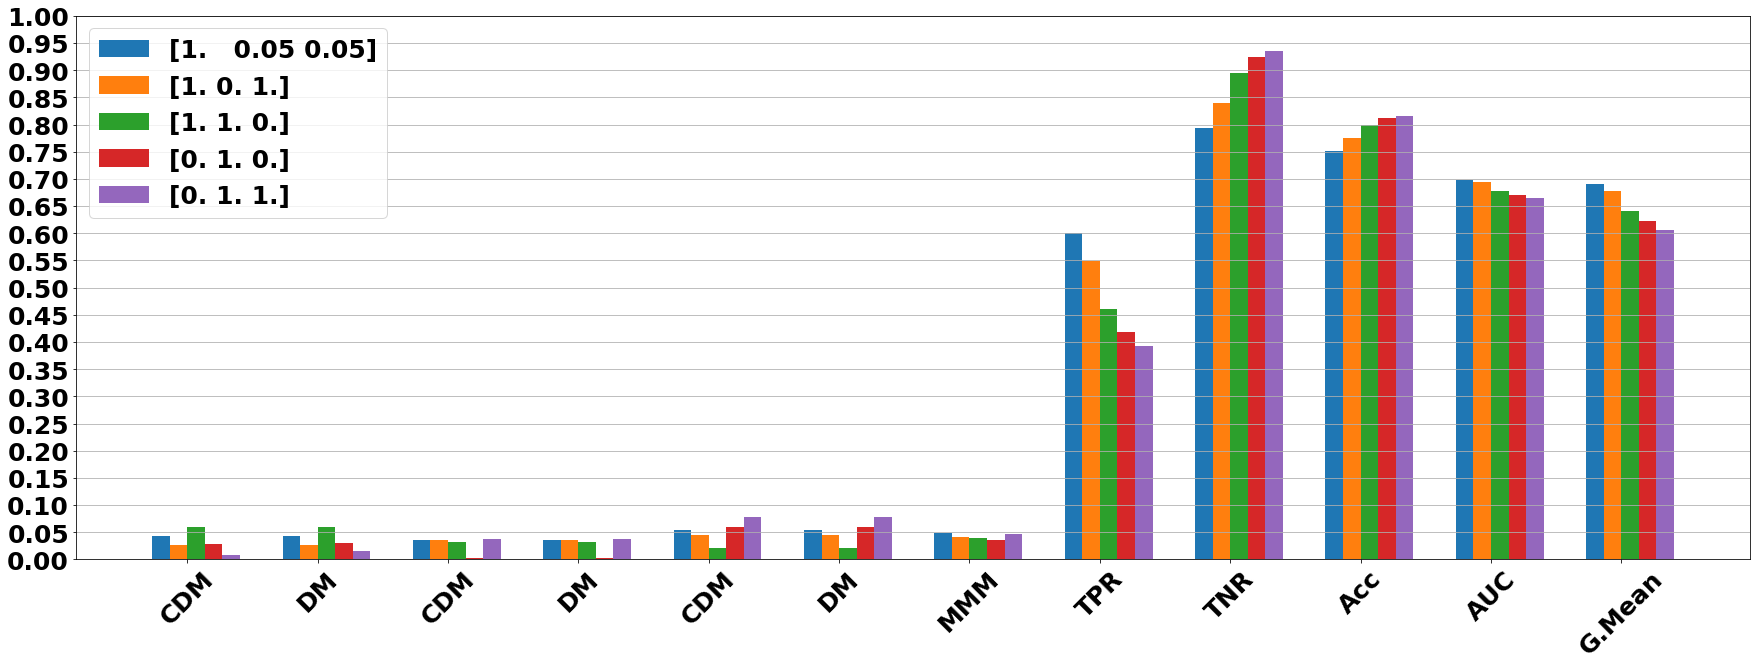

In [20]:
dt='Credit'
vis('',results,performance,L=protected,dt=dt,clfs=list(reference_performance_map.keys()))

In [21]:
protected    #SEX               #MARRIAGE            #AGE

['SEX', 'MARRIAGE', 'AGE']